In [21]:
# import dependencies
from obspy import read, Stream
from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from obspy.core.inventory import read_inventory
import sys, os
sys.path.append('/Users/thompsong/src/volcanoObsPy/LIB')
import libseisGT as ls
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth

rundir = '/Users/thompsong/DATA/HAITI_2010'
if not os.path.exists(rundir):
    os.mkdir(rundir)
os.chdir(rundir)

## haitiEQ parameters
haitiEQ = dict()
haitiEQ['otime'] = UTCDateTime(2010, 1, 12, 21, 53, 10, 200000)
haitiEQ['lat'] = 18.45
haitiEQ['lon'] = -72.55
haitiEQ['depth'] = 13.0
haitiEQ['mag'] = 7.0
GCMTeventID = '201001122153A'

## Well parameters
# L‐31NN
l31nn = dict()
l31nn['lat'] = 25.746
l31nn['lon'] = -80.498

# L‐31NS
l31ns = dict()
l31ns['lat'] = 25.702
l31ns['lon'] = -80.496

# waveform data time window
pretrigsecs = 600
posttrigsecs = 1800
wstart = haitiEQ['otime'] - pretrigsecs
wend = haitiEQ['otime'] + posttrigsecs

In [2]:
# Predicted phase arrival times at SFWMD wells
l31nn = ls.predict_arrival_times(l31nn, haitiEQ)
l31ns = ls.predict_arrival_times(l31ns, haitiEQ)
print('Station   \t   L-31NN\t   L-31NS')
print('Lat (deg) \t%9.3f\t%9.3f' % (l31nn['lat'], l31ns['lat']))
print('Lon (deg) \t%9.3f\t%9.3f' % (l31nn['lon'], l31ns['lon']))
print('Dist (deg)\t%9.3f\t%9.3f' % (l31nn['distance'], l31ns['distance']))

print('Phase      \tPredicted arrival time on 2010/01/12')
keys = l31nn['phases'].keys()
for key in keys:
    if len(key)<9:
        print('%s      \t %s\t %s' % (key.rjust(9), l31nn['phases'][key], l31ns['phases'][key]))

Station   	   L-31NN	   L-31NS
Lat (deg) 	   25.746	   25.702
Lon (deg) 	  -80.498	  -80.496
Dist (deg)	   10.348	   10.316
Phase      	Predicted arrival time on 2010/01/12
        P      	 21:55:38	 21:55:37
       Pn      	 21:55:38	 21:55:38
       pP      	 21:56:28	 21:56:27
       sP      	 21:55:43	 21:55:42
       PP      	 21:56:28	 21:56:27
        S      	 21:57:35	 21:57:34
 Rayleigh      	 21:57:58	 21:57:57
       Sn      	 21:57:35	 21:57:35
       sS      	 21:58:52	 21:58:51
       SS      	 21:58:52	 21:58:51
      PcP      	 22:01:44	 22:01:44
      ScP      	 22:05:16	 22:05:16
      PcS      	 22:05:17	 22:05:17
      ScS      	 22:08:51	 22:08:51
    PKiKP      	 22:09:43	 22:09:43
   pPKiKP      	 22:09:48	 22:09:48
   sPKiKP      	 22:09:49	 22:09:49
    SKiKP      	 22:13:14	 22:13:14
 PKIKKIKP      	 22:24:59	 22:24:59
 SKIKKIKP      	 22:28:30	 22:28:30
 PKIKKIKS      	 22:28:31	 22:28:31
 SKIKKIKS      	 22:32:02	 22:32:02
   PKPPKP      	 22:36:39	 22:36:39

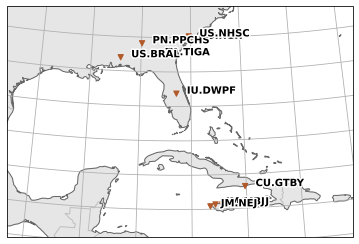

In [3]:
# get seismic station inventory around South Florida
client = Client("IRIS")
searchRadius = 8 #12 # degrees
stationXMLfile = '20100112_haiti_eq_%ddegrees.xml' % searchRadius
if os.path.exists(stationXMLfile):
    invFL = read_inventory(stationXMLfile)
else:
    invFL = ls.get_FDSN_inventory(client, haitiEQ['otime'], stationXMLfile, '??', l31nn['lat'], l31nn['lon'], searchRadius, 3600 * 12, 3600 * 12 )

invFL = invFL.remove(network='SY') # remove synthetic seismograms - they are blank anyway
invFL = invFL.select(channel="[BESH]H[ZNE12RT]") # select only the seismic channels
# not that inventories are not modified in place. results have to be assigned to a variable.
#print(invFL)
#invFL.plot(projection='local')
invFL.plot(outfile=stationXMLfile.replace('.xml','.png'),projection='local',resolution='h',size=28);
                                                                                                   

In [4]:
# get corresponding raw seismic data
trace_ids = ls.inventory2traceid(invFL)
rawfile = '20100112_haiti_eq_%ddegrees.mseed' % searchRadius
if os.path.exists(rawfile):
    #os.remove(rawfile)
    st = read(rawfile)
else:        
    st = ls.get_FDSN_Stream(client, trace_ids, rawfile, wstart, wend )
    st.attach_response(invFL) 
    st.write(rawfile)                                                                                         

## instrument correction to velocity, acceleration and displacement
# Stream objects are modified in place and passed by address to new functions. Do not need to assign return values to variables.
# can also loop over tr in st and st.remove(tr) without causing harm
st = read(rawfile)

# clean data & add metadata
ls.attach_station_coordinates_from_inventory(invFL, st)
for tr in st:
    tr.detrend("spline", order=3, dspline=500)
    #tr.filter("bandpass", freqmin = 1/40, freqmax = 1/5, corners=1, zerophase=True)
    d = gps2dist_azimuth(haitiEQ['lat'], haitiEQ['lon'], tr.stats.latitude, tr.stats.longitude)
    tr.stats.distance = d[0]
    tr.stats.azimuth = d[1]

# reconstitute to displacement
fil = (0.01, 0.015, 30.0, 45.0)
stD = st.copy()
ls.removeInstrumentResponse(stD, preFilter = fil, outputType = "DISP", inventory = invFL)

# save displacement miniseed file
dispfile = '20100112_haiti_eq_%ddegrees_disp.mseed' % searchRadius
if not os.path.exists(dispfile):
    stD.write(dispfile)

# plot seismogram
pngplotfile = dispfile.replace('.mseed','.png')
if not os.path.exists(pngplotfile):
    stD.plot(outfile=pngplot, equal_scale=False, reftime = haitiEQ['otime'])

# get Z-component
stZ = stD.copy().select(channel="[ESBH]HZ")
stZ.trim(haitiEQ['otime']-70, haitiEQ['otime']+890 )
zfile = dispfile.replace('.mseed','_Z.mseed')
if not os.path.exists(zfile):
    stZ.write(zfile)
    
# plot record section   
pngrecordfile = pngplotfile.replace('.png', '_recordsection.png')
if not os.path.exists(pngrecordfile):
    stZ.plot(type='section', outfile = pngrecordfile, reftime = haitiEQ['otime']);

# compute peak vector amplitude
print('Real 3-component vector amplitudes:')
print('station, PGD (m), PGV (m/s), PGA (m/s-2)')
for tr in stZ:
    thisID = tr.id[:-1]
    #st3c = stD.select(id = '%s[ENZ12RT]' % thisID)
    st3c = stD.copy().select(id = '%s[ENZ12RT]' % thisID)
    md = ls.max_3c(st3c)
    mv = ls.max_3c(st3c.differentiate())
    ma = ls.max_3c(st3c.differentiate())
    print('%s, %4.2e, %4.2e, %4.2e' % (thisID, md[0], mv[0], ma[0])) 
    tr.stats['PGD'] = md[0]
    tr.stats['PGV'] = mv[0]   
    tr.stats['PGA'] = ma[0]

Real 3-component vector amplitudes:
station, PGD (m), PGV (m/s), PGA (m/s-2)
CO.CSB.00.EH, 2.24e+00, 1.77e+00, 2.93e+00
CU.GTBY..BH, 2.72e-02, 1.82e-02, 4.93e-02
IU.DWPF.00.BH, 1.13e-08, 2.03e-08, 4.07e-07
TA.TIGA..BH, 7.88e-03, 3.30e-03, 1.87e-03
US.BRAL..BH, 9.39e-03, 4.53e-03, 2.83e-03
US.NHSC.00.BH, 2.23e-03, 1.12e-03, 8.27e-04


# Synthetic data

In [22]:
synthmseedfile = '%s_syngine.mseed' % GCMTeventID
if os.path.exists(synthmseedfile):
    stSyn = read(synthmseedfile)
else:
    stSyn = Stream()
    for tr in stZ:
        if 'latitude' in tr.stats:
            s = tr.stats
            sta = s.network + '.' + s.station
            mseedfile = sta + '_syngine.mseed'
            if os.path.exists(mseedfile):
                this_st = read(mseedfile)
            else:
                try:
                    this_st = ls.syngine2stream(sta, s.latitude, s.longitude, GCMTeventID, mseedfile)
                except:
                    print('Syngine failed for %s' % sta)
                    next
            for this_tr in this_st:
                print('Adding metadata for %s' % tr.id)
                this_tr.stats.station = s.station
                this_tr.stats.latitude = s.latitude
                this_tr.stats.longitude = s.longitude
                this_tr.stats.distance = s.distance
                stSyn.append(this_tr)
                
                
    # Add the water stations
    l31nnmseed = 'l31nn_syngine.mseed'
    if os.path.exists(l31nnmseed):
        this_st = read(l31nnmseed)
    else:
        try:
            this_st = ls.syngine2stream('L31NN', l31nn['lat'], l31nn['lon'], GCMTeventID, l31nnmseed)
        except:
            print('Syngine failed for %s' % sta) 
    for this_tr in this_st:
        this_tr.stats.station = 'L31NN'
        this_tr.stats.latitude = l31nn['lat']
        this_tr.stats.longitude = l31nn['lon']
        this_tr.stats.distance = l31nn['distance']
        stSyn.append(this_tr)  
   

    # Add the astronaut beach house
    bchh = dict()
    bchh['lat'] = 28.5744
    bchh['lon'] = -80.5721
    bchhmseed = 'bchh_syngine.mseed'
    if os.path.exists(bchhmseed):
        this_st = read(bchhmseed)
    else:    
        try:
            this_st = ls.syngine2stream('BCHH', bchh['lat'], bchh['lon'], GCMTeventID, bchhmseed)
        except:
            print('Syngine failed for %s' % sta)
    for this_tr in this_st:
        this_tr.stats.station = 'BCHH'
        this_tr.stats.latitude = bchh['lat']
        this_tr.stats.longitude = bchh['lon']
        d = gps2dist_azimuth(haitiEQ['lat'], haitiEQ['lon'], bchh['lat'], bchh['lon'])
        this_tr.stats.distance = d[0]
        this_tr.stats.azimuth = d[1]
        stSyn.append(this_tr)

    
    # trim and save data
    stSyn.trim(haitiEQ['otime']-70, haitiEQ['otime']+890 )
    stSyn.write(synthmseedfile)

# make plots
syn_plot_png = synthmseedfile.replace('.mseed', '.png')
if not os.path.exists(syn_plot_png):
    stSyn.plot(outfile = syn_plot_png, reftime = haitiEQ['otime']);
syn_section_png = synthmseedfile.replace('.mseed', '_section.png')

stSynZ = stSyn.copy().select(channel="[ESBH]XZ")
if not os.path.exists(syn_section_png):
    stSynZ.plot(type='section', outfile = syn_section_png, reftime = haitiEQ['otime']);

# compute peak vector amplitude
print('Synthetic 3-component vector amplitudes:')
print('station, PGD (m), PGV (m/s), PGA (m/s-2)')
for tr in stSynZ:
    thisID = tr.id[:-1]
    st3c = stSyn.copy().select(id = '%s[ENZ12RT]' % thisID)
    if len(st3c)==3:
        md = ls.max_3c(st3c)
        mv = ls.max_3c(st3c.differentiate())
        ma = ls.max_3c(st3c.differentiate())
        print('%s, %4.2e, %4.2e, %4.2e' % (thisID, md[0], mv[0], ma[0])) 
        tr.stats['PGD'] = md[0]
        tr.stats['PGV'] = mv[0]   
        tr.stats['PGA'] = ma[0]

Synthetic 3-component vector amplitudes:
station, PGD (m), PGV (m/s), PGA (m/s-2)
XX.CSB.SE.BX, 2.07e-02, 1.82e-02, 1.58e-02
XX.GTBY.SE.BX, 2.68e-02, 2.95e-02, 3.32e-02
XX.DWPF.SE.BX, 2.41e-02, 1.85e-02, 2.11e-02
XX.TIGA.SE.BX, 1.82e-02, 1.64e-02, 1.49e-02
XX.BRAL.SE.BX, 1.35e-02, 1.11e-02, 1.16e-02
XX.NHSC.SE.BX, 2.02e-02, 1.63e-02, 1.43e-02
XX.L31NN.SE.BX, 2.22e-02, 2.25e-02, 2.34e-02
XX.BCHH.SE.BX, 2.67e-02, 2.03e-02, 2.41e-02


In [16]:
a=3/3
a.is_integer()

True